In [24]:
import fastf1 as ff1
import matplotlib.pyplot as plt
import os
os.chdir('..')  # Changes the working directory to the parent directory
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import plotly.graph_objects as go
import plotly.offline as pyo

### Loading the data
Dividing race data into seasons

In [30]:
import os
os.chdir('..')  # Changes the working directory to the parent directory
race_data = pd.read_csv('C:/Users/havva/Desktop/Datamatiker/4 Semester/Python/Exam_Project/data/lap_times.csv')
print(race_data.head())

## Separate the data from 2018 to 2023 into a new dataframe
race_data_2018_2023 = race_data[(race_data['raceId'] >= 989) & (race_data['raceId'] <= 1110)]

'''RACE DATA INFO'''
print(race_data_2018_2023.info())
print(race_data_2018_2023.notnull().sum())

year_intervals = {
    2018: (989, 1009),
    2019: (1010, 1030),
    2020: (1031, 1047),
    2021: (1052, 1073),
    2022: (1074, 1096),
    2023: (1098, 1110)
}
# Dictionary to store each season's data
dataframes_race = {}
# Extracting each unique raceId for the seasons
unique_raceIds = race_data_2018_2023['raceId'].unique()
# Looping through the dictionary to extract the data for each season
for year, (start, end) in year_intervals.items():
    dataframes_race[year] = race_data_2018_2023[
        (race_data_2018_2023['raceId'] >= start) & (race_data_2018_2023['raceId'] <= end)]

   raceId  driverId  lap  position      time  milliseconds
0     841        20    1         1  1:38.109         98109
1     841        20    2         1  1:33.006         93006
2     841        20    3         1  1:32.713         92713
3     841        20    4         1  1:32.803         92803
4     841        20    5         1  1:32.342         92342
<class 'pandas.core.frame.DataFrame'>
Index: 125109 entries, 426633 to 551741
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   raceId        125109 non-null  int64 
 1   driverId      125109 non-null  int64 
 2   lap           125109 non-null  int64 
 3   position      125109 non-null  int64 
 4   time          125109 non-null  object
 5   milliseconds  125109 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 6.7+ MB
None
raceId          125109
driverId        125109
lap             125109
position        125109
time            125109
milliseconds    125109

In [31]:
      # Creating DF for season 2018
df_race_2018 = dataframes_race[2018]

## Exploration and analysis of the race_data_2018-2023
### Histogram to show the distribution of the lap times
Based on the histograms, we can see the race data is not normally distributed across across the season.
The data seems to be bimodal, which suggests that there are two distinct subgroups within the data.
The indication of distinct subgroups could be due to various factors llike skill, track conditions or strategy..

C:\Users\havva\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



([<matplotlib.axis.XTick at 0x2664f0f40d0>,
 [Text(66000, 0, '66000'),
  Text(76000, 0, '76000'),
  Text(86000, 0, '86000'),
  Text(96000, 0, '96000'),
  Text(106000, 0, '106000'),
  Text(116000, 0, '116000'),
  Text(126000, 0, '126000'),
  Text(136000, 0, '136000'),
  Text(146000, 0, '146000'),
  Text(156000, 0, '156000'),
  Text(166000, 0, '166000'),
  Text(176000, 0, '176000'),
  Text(186000, 0, '186000'),
  Text(196000, 0, '196000')])

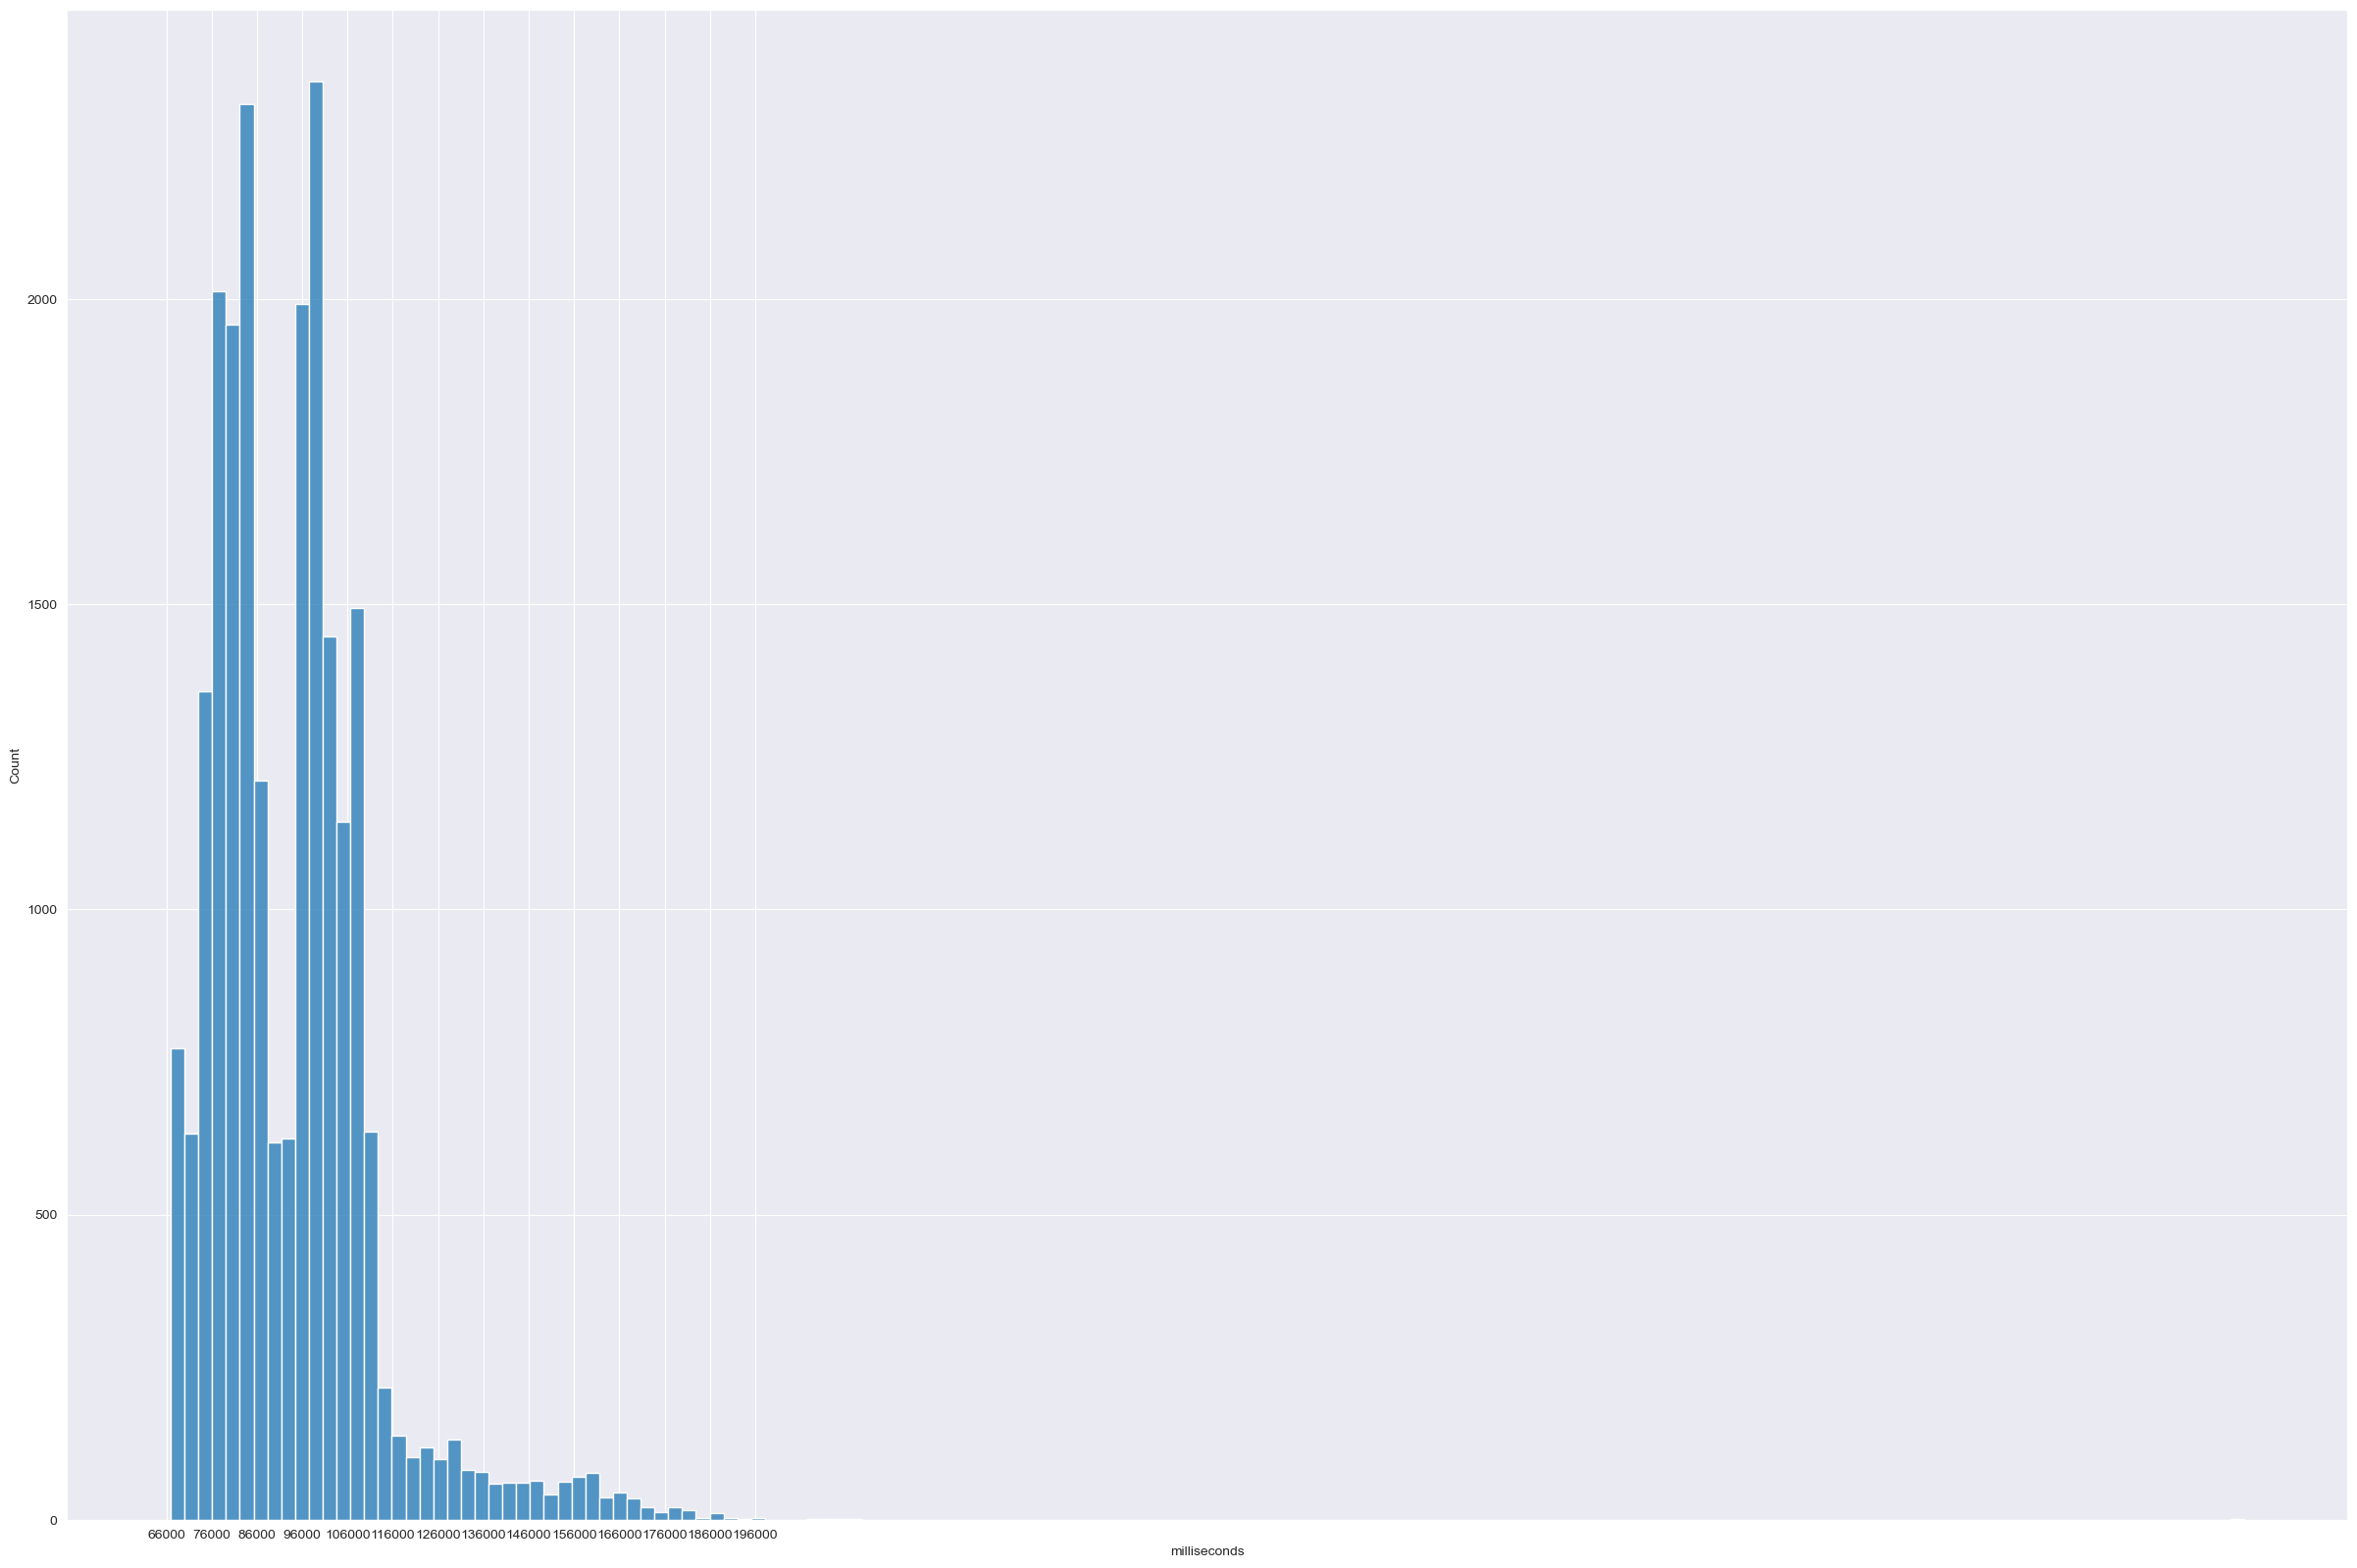

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(30, 20))
sns.histplot(df_race_2018['milliseconds'], bins=150)
plt.xticks(np.arange(66000, 200000, 10000))

##### Further analysis of the data to identify potential outliers.
The histogram and the describe functions both show, that there is an outlier at +500000 milliseconds and potientially at around 200000 milliseconds.

C:\Users\havva\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



80151.0 102030.0 21879.0


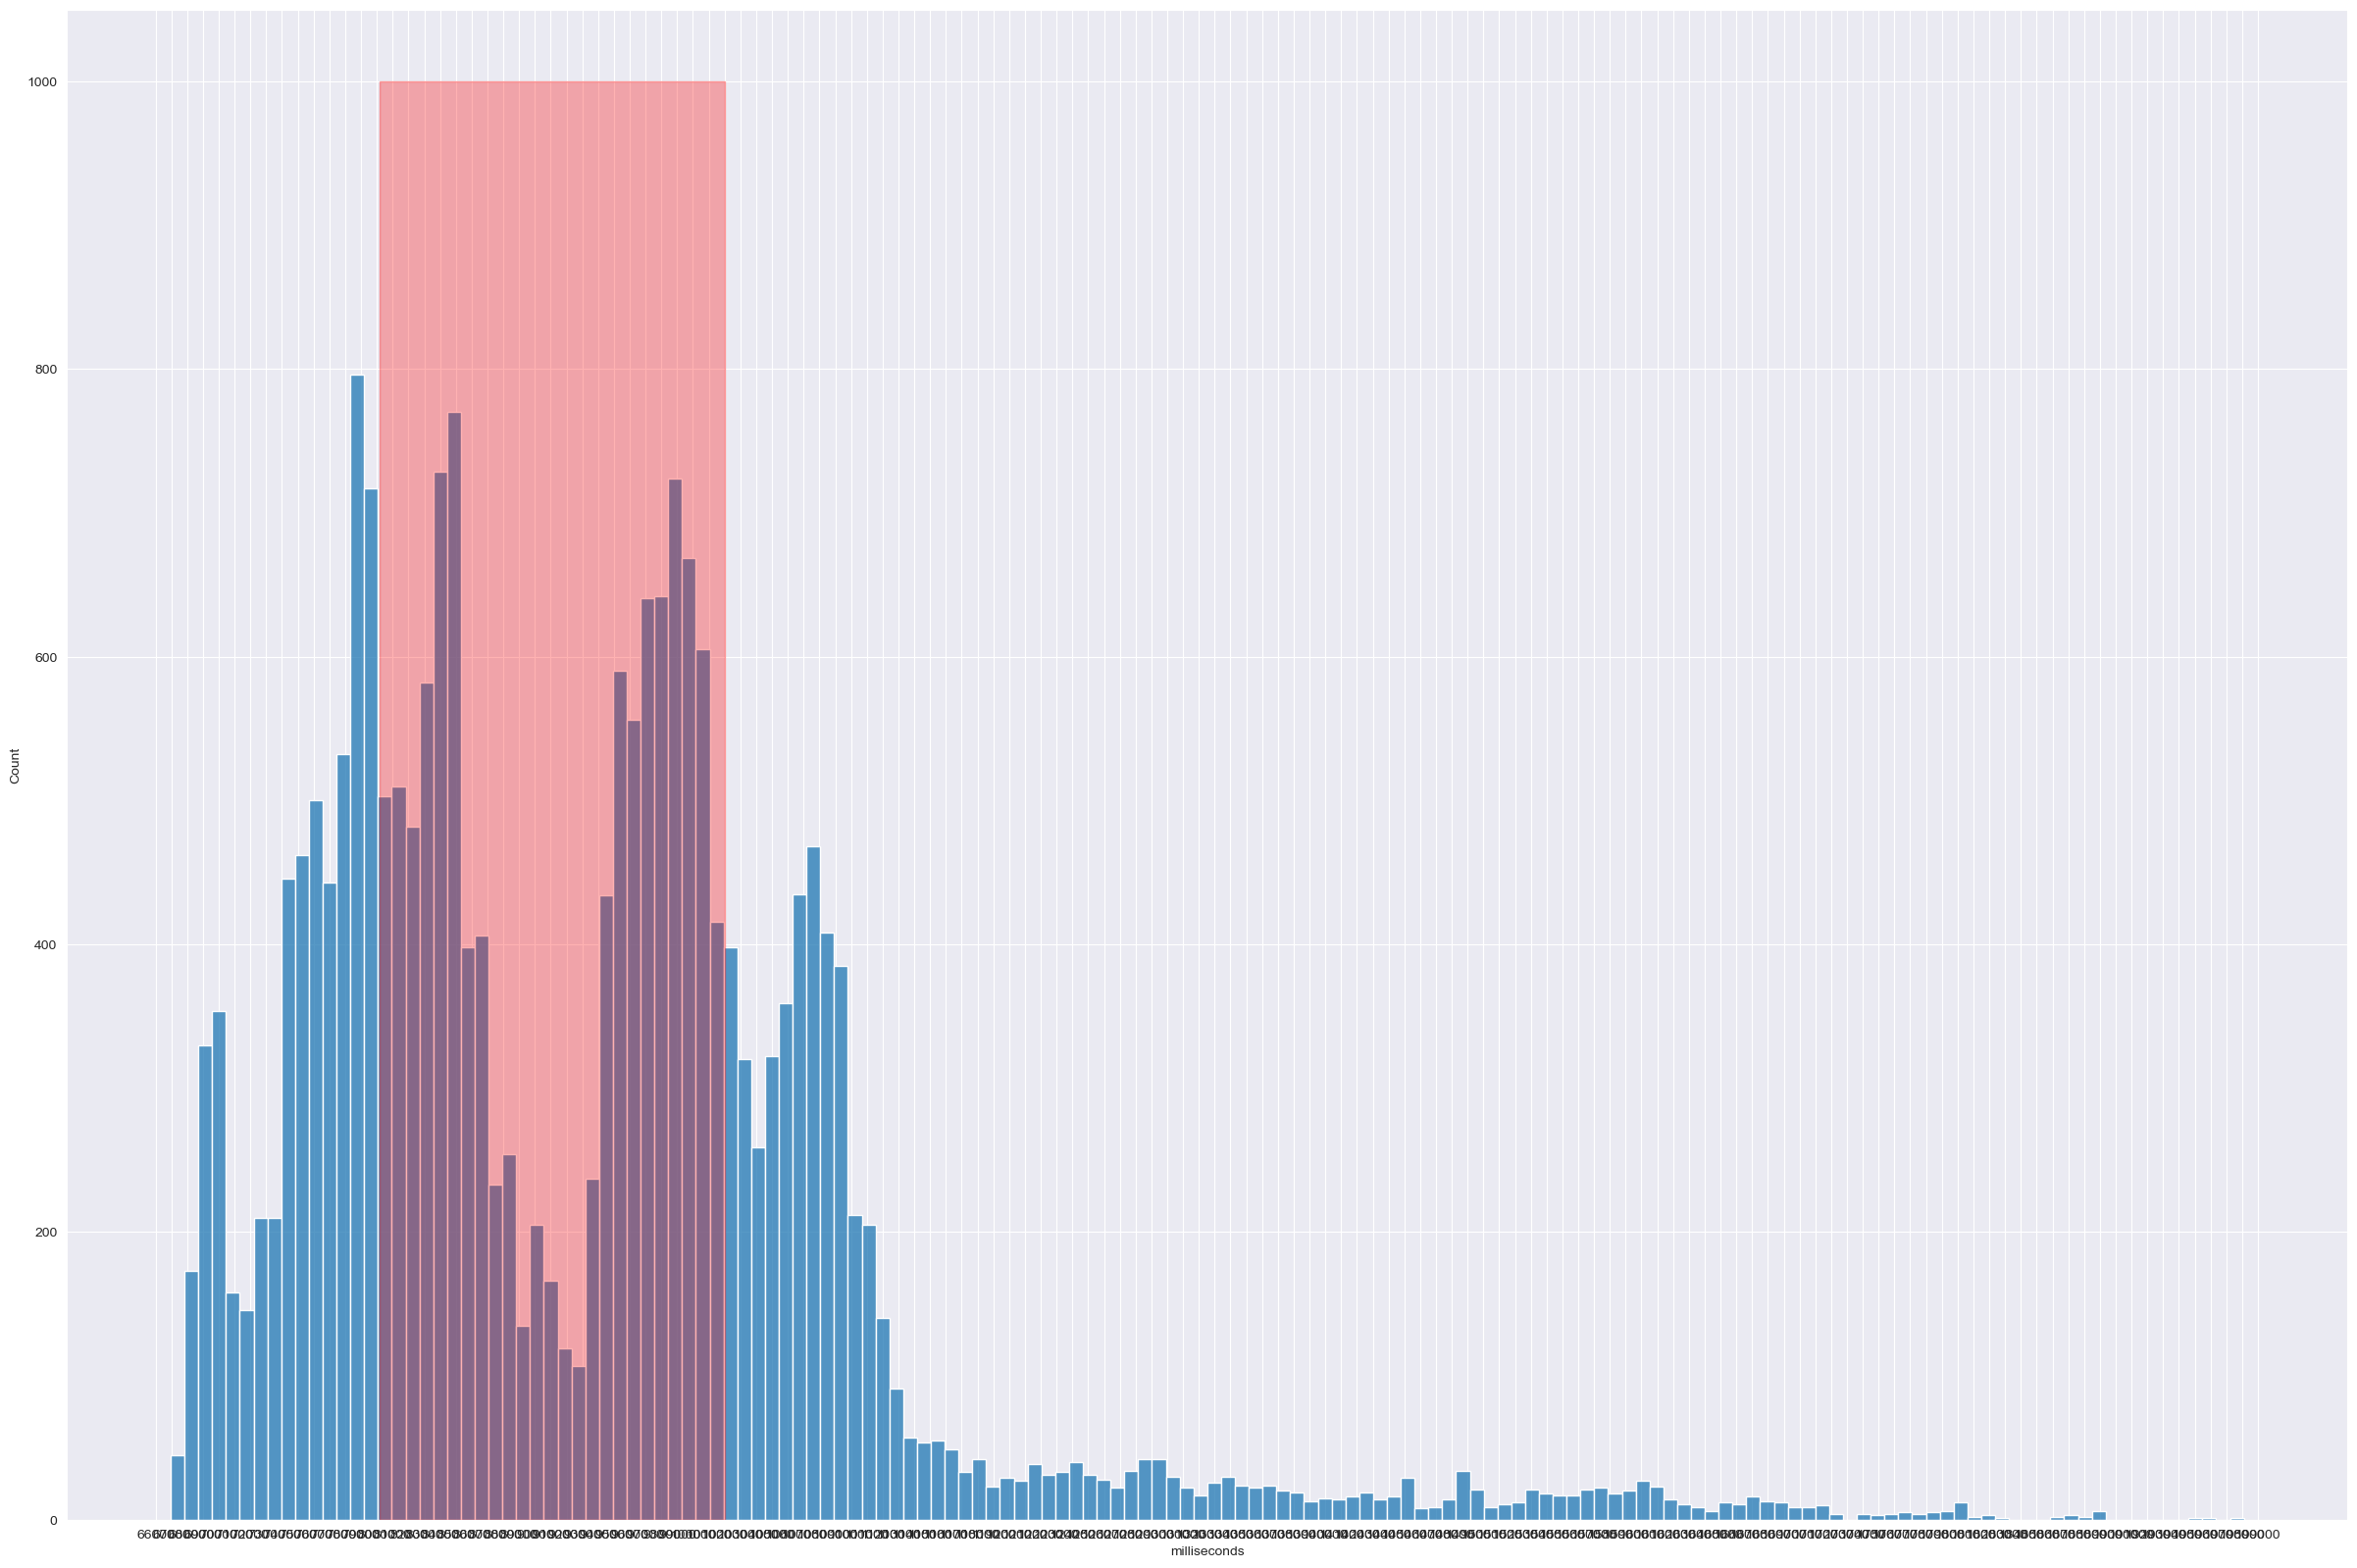

In [33]:
df_race_2018 = df_race_2018[(df_race_2018['milliseconds'] <= 200000) & (df_race_2018['milliseconds'] >= 66000)]

fig, axs = plt.subplots(1, 1, figsize=(30, 20))
sns.histplot(df_race_2018['milliseconds'], bins=150)
plt.xticks(np.arange(66000, 200000, 1000))

df_race_2018.describe()

Q1 = df_race_2018['milliseconds'].quantile(0.25)
Q3 = df_race_2018['milliseconds'].quantile(0.75)
IQR = Q3 - Q1
print(Q1, Q3, IQR)
axs.fill_betweenx([0, 1000], Q1, Q3, color='red', alpha=0.3)

#### Extracting the driver data

In [34]:
driver_race_times = df_race_2018.groupby('driverId')[['driverId', 'raceId', 'lap','milliseconds']].apply(lambda x: x)
driver_race_times['driverId_cat'] = pd.Categorical(df_race_2018['driverId']).codes

### Identifying outliers on a per race basis.
First, we calculate the mean, standard deviation, minimum and maximum for each race in the season. 

The threshold is set to 3 times the standard deviation for each race. This is a common method to identify outliers in a dataset.

In [35]:
track_stats = df_race_2018.groupby('raceId')['milliseconds'].agg(['mean', 'std', 'min', 'max'])
threshold = 3
driver_race_times['outlier'] = driver_race_times.apply(lambda x: x['milliseconds'] > track_stats.loc[x['raceId']]['mean'] + threshold * track_stats.loc[x['raceId']]['std'], axis=1)

### Scatter plot of the driver data with outliers marked.

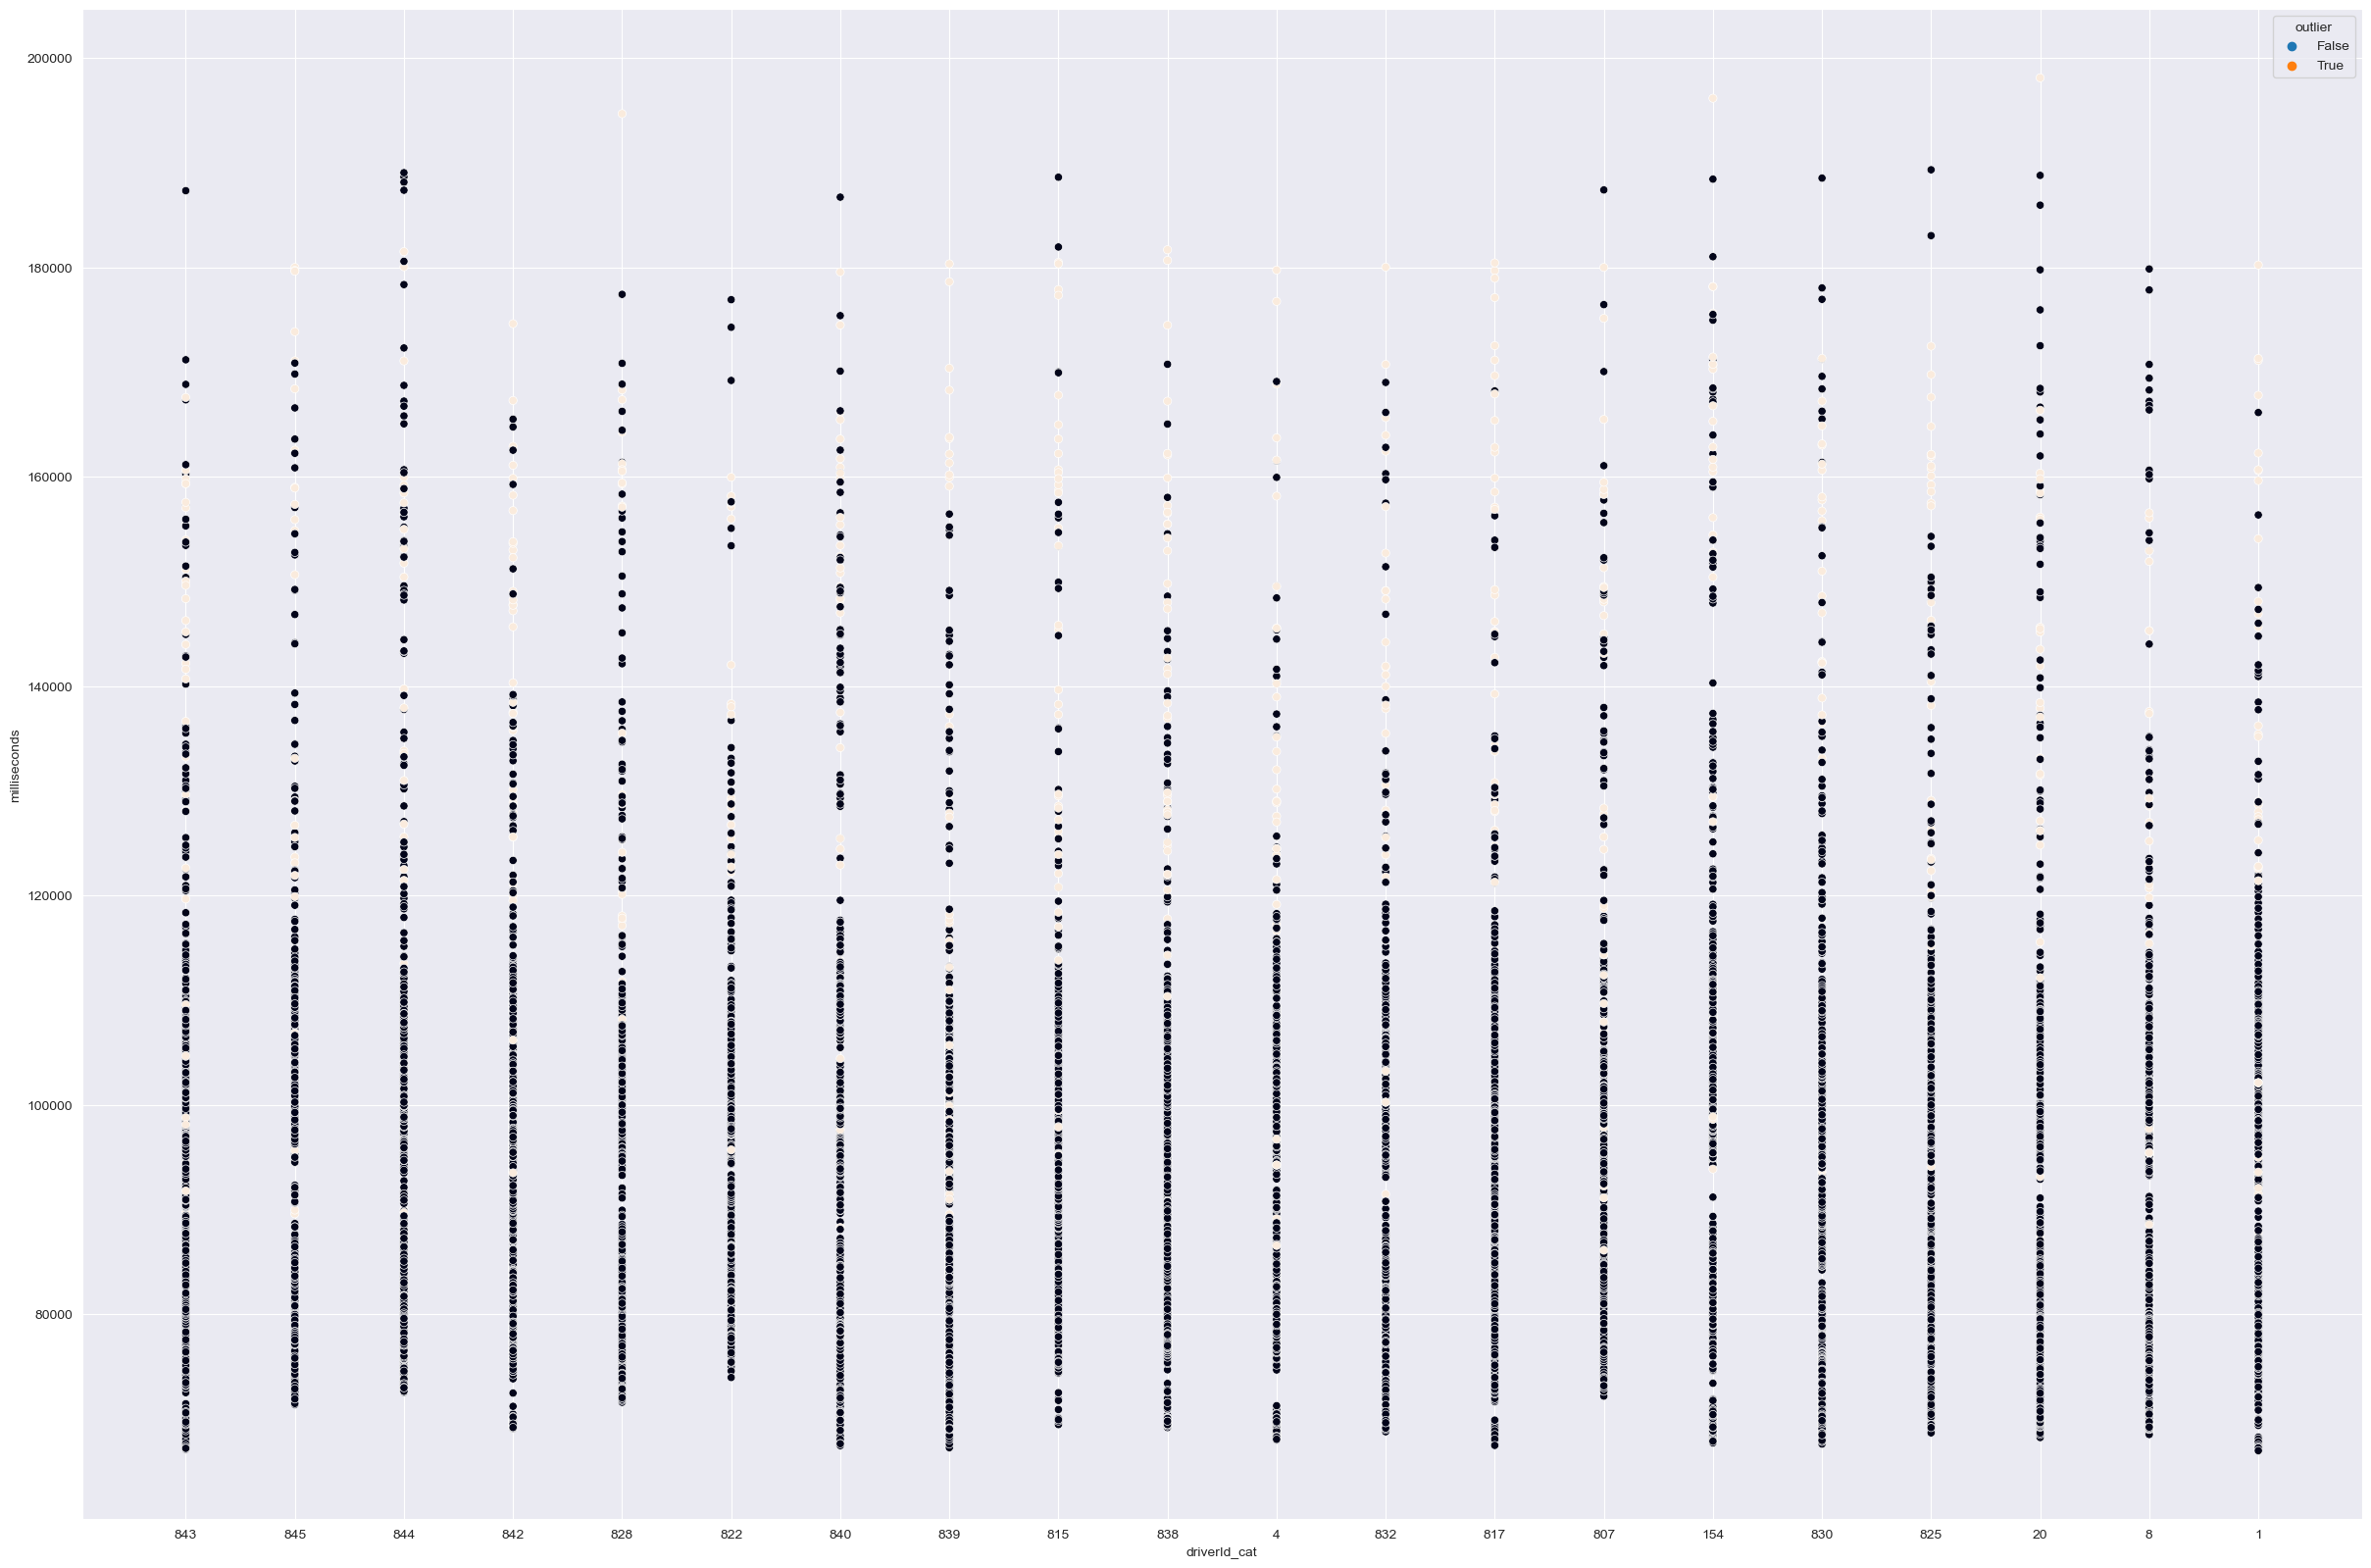

In [48]:
race_ids = df_race_2018['raceId'].unique()
driver_ids = df_race_2018['driverId'].unique()
colors = sns.color_palette('deep', len(race_ids))
color_map1 = dict(zip(race_ids, colors))
fig, axs = plt.subplots(1, 1, figsize=(30, 20))

sns.scatterplot(x='driverId_cat', y='milliseconds', c=driver_race_times['outlier'], data=driver_race_times, hue='outlier')

axs.set_xticks(range(len(driver_ids)))
axs.set_xticklabels(driver_ids)

plt.show()

##### Removing the outliers from the data
Removing outliers to get a better understanding of the distribution of the lap times.

C:\Users\havva\AppData\Local\Temp\ipykernel_11376\1464983951.py:3: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



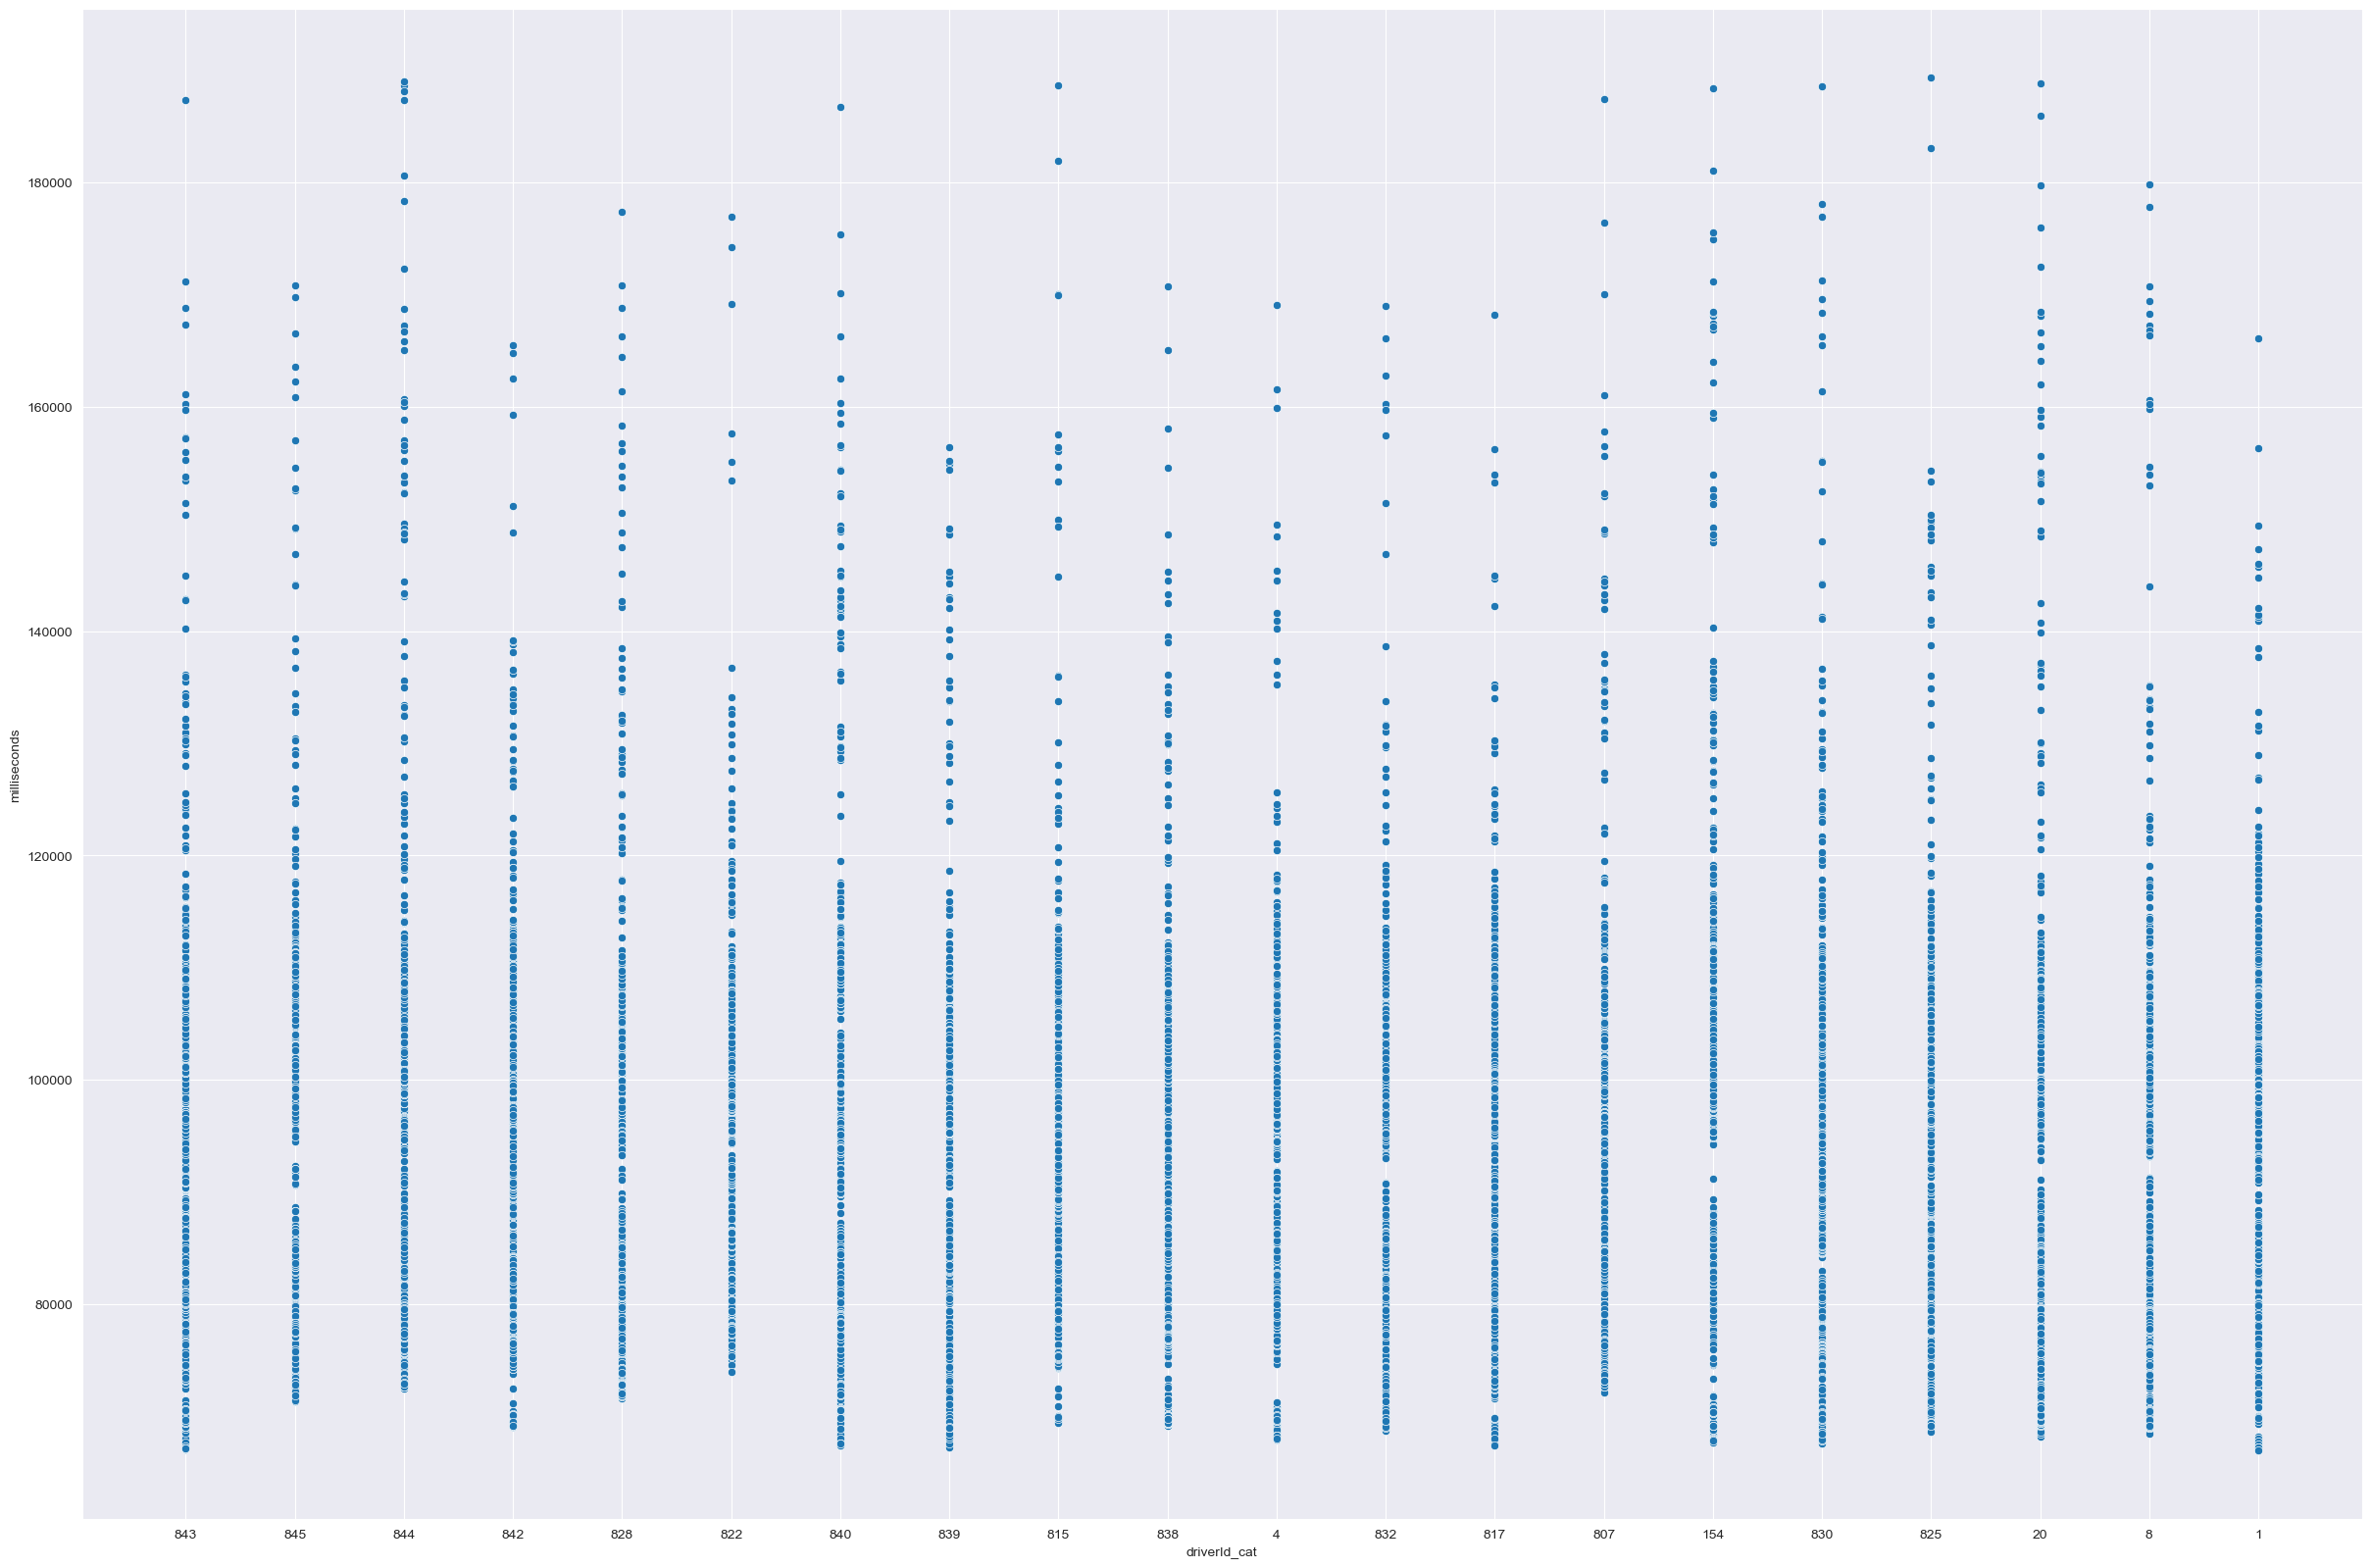

In [37]:
driver_race_times_no_outliers = driver_race_times[driver_race_times['outlier'] == False]
fig, axs = plt.subplots(1, 1, figsize=(30, 20))
sns.scatterplot(x='driverId_cat', y='milliseconds', data=driver_race_times_no_outliers, palette=color_map1)
axs.set_xticks(range(len(driver_ids)))
axs.set_xticklabels(driver_ids)
plt.show()

##### A new histogram is plotted to show the distribution of the lap times without the outliers.
Q1 = 79876.0: This is the first quartile (25th percentile) of lap times. 25% of the laps in the 2018 season were completed in 79.876 seconds or less.
Q3 = 101094.25: This is the third quartile (75th percentile). 75% of the laps were completed in 101.094 seconds or less.
IQR = 21218.25: The interquartile range (IQR) represents the middle 50% of the lap times. This indicates that 50% of the laps fell within a range of about 21.2 seconds.

C:\Users\havva\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



79876.0 101094.25 21218.25


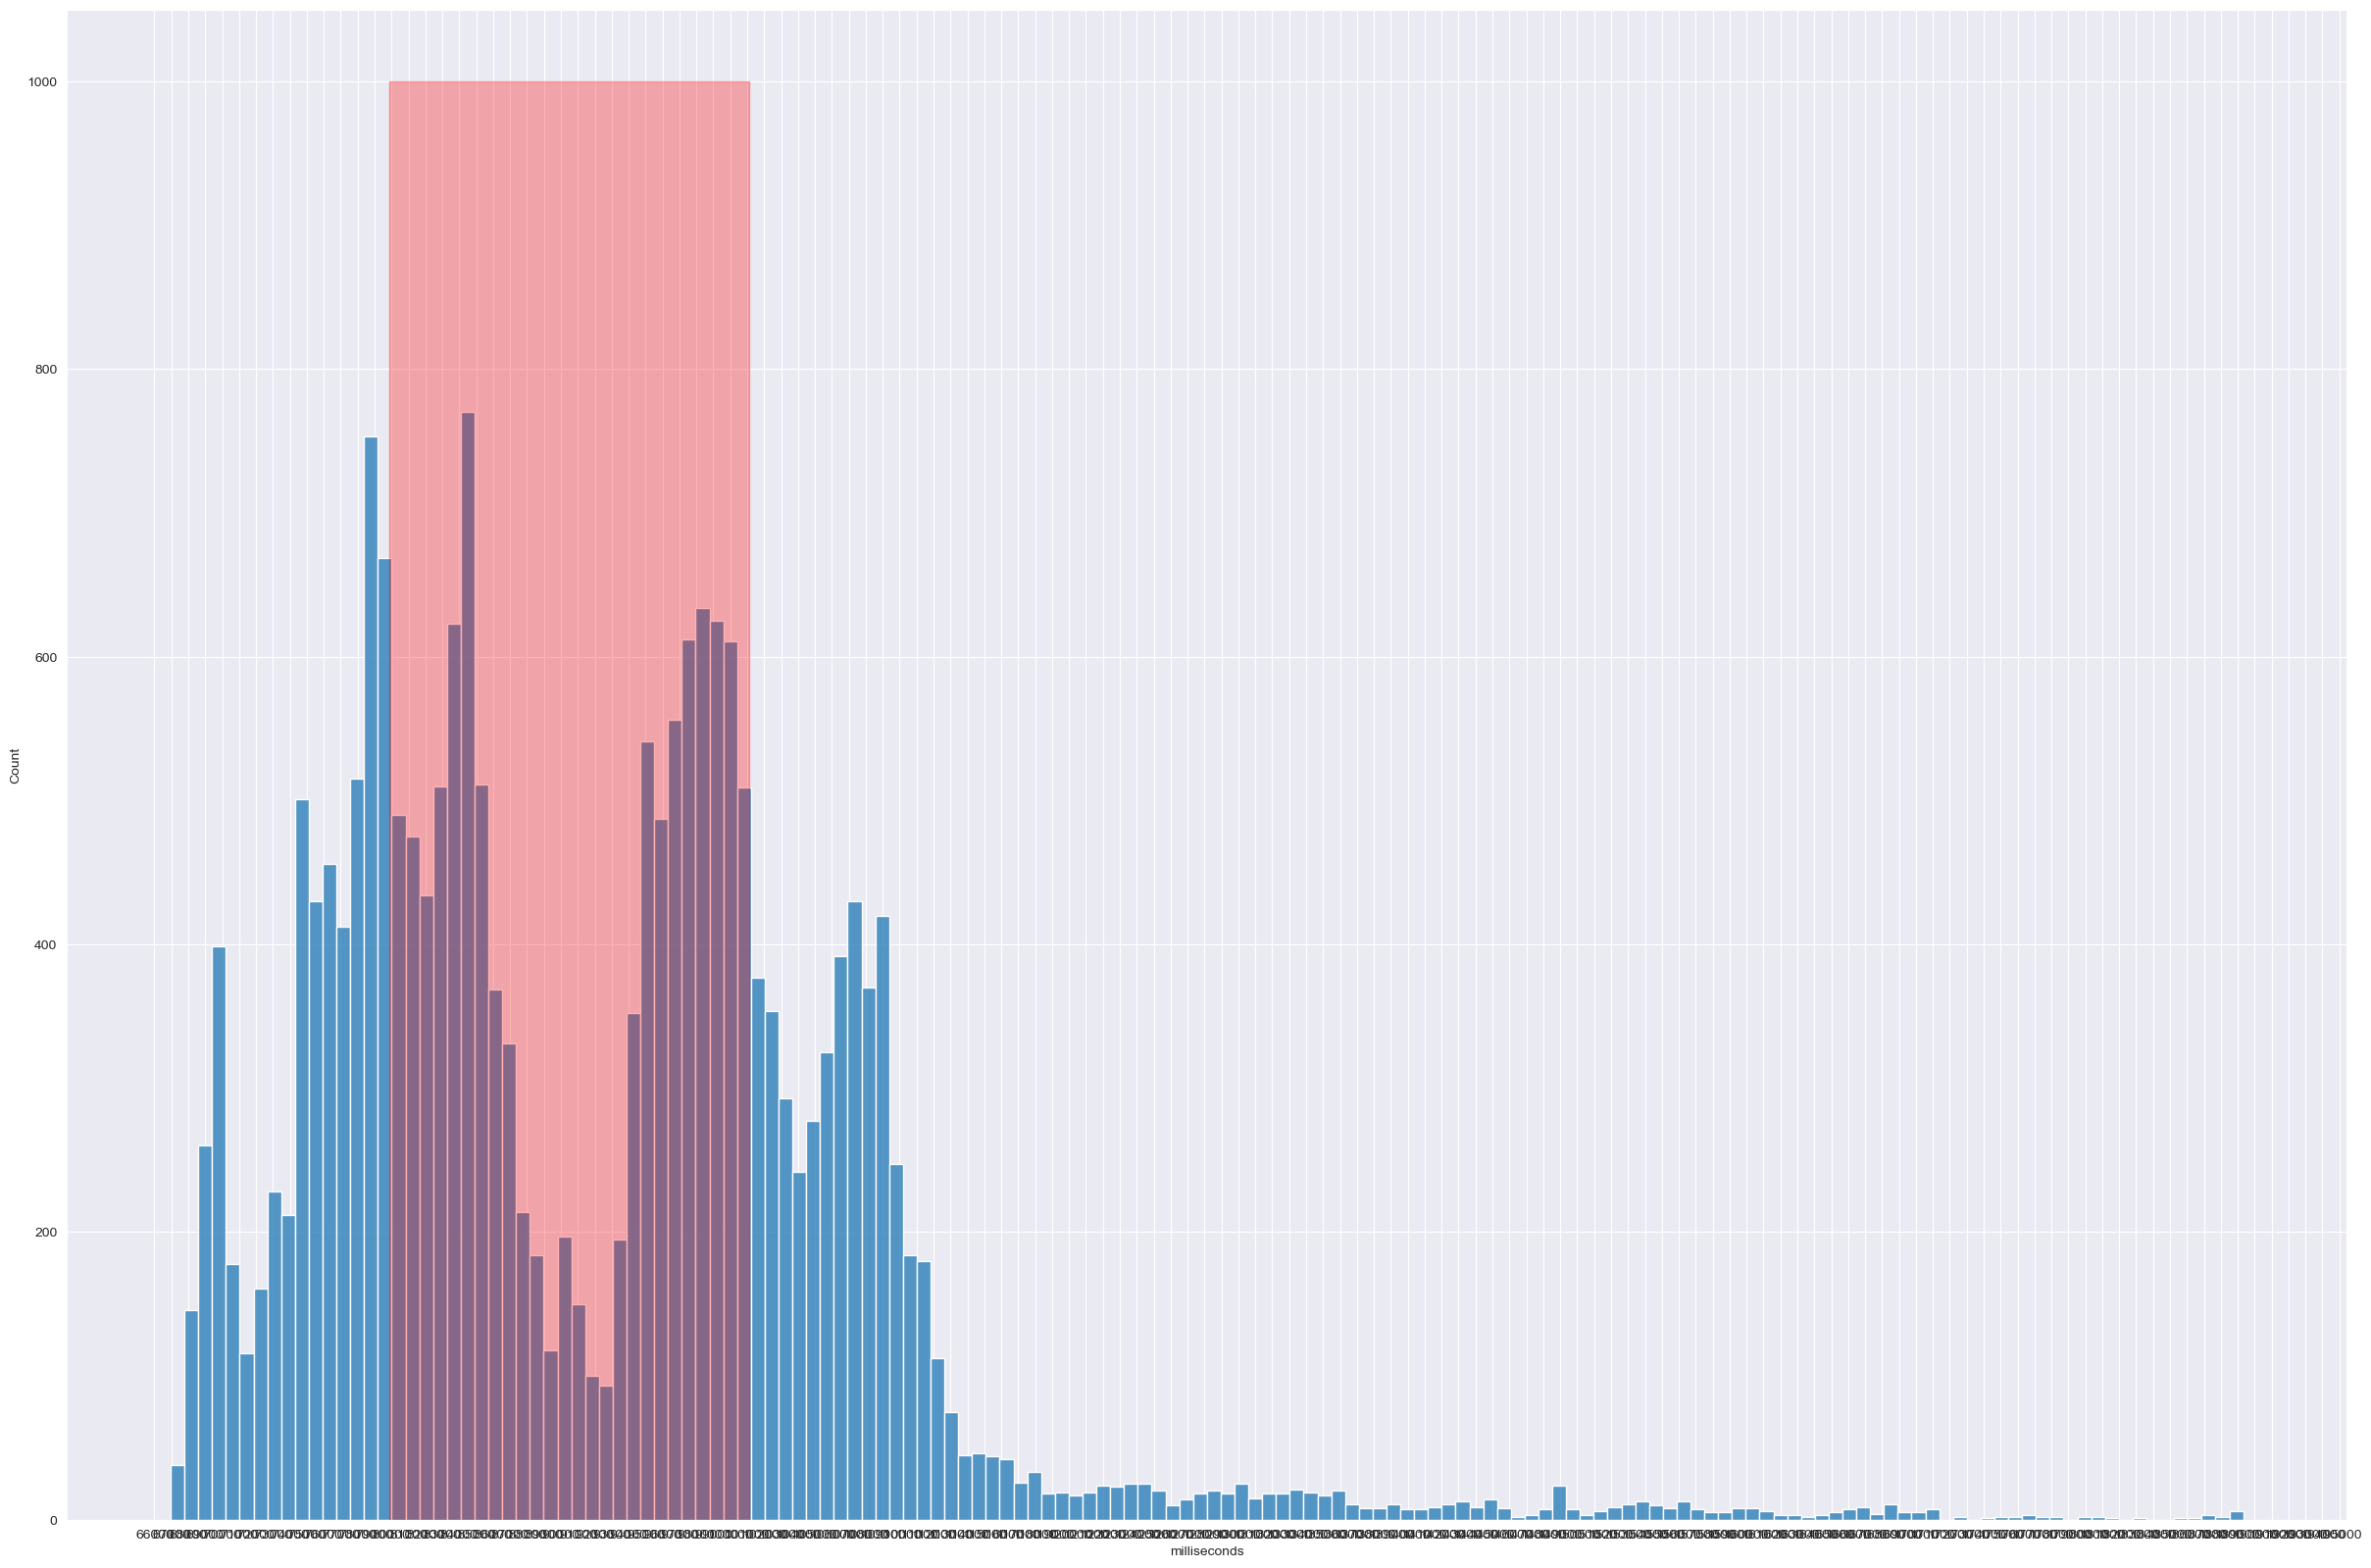

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(30, 20))
sns.histplot(driver_race_times_no_outliers['milliseconds'], bins=150)
plt.xticks(np.arange(66000, 200000, 1000))

df_race_2018.describe()

Q1 = driver_race_times_no_outliers['milliseconds'].quantile(0.25)
Q3 = driver_race_times_no_outliers['milliseconds'].quantile(0.75)
IQR = Q3 - Q1
print(Q1, Q3, IQR)
axs.fill_betweenx([0, 1000], Q1, Q3, color='red', alpha=0.3)

### Applying a KDE to the data to identify the distribution of the data and the number of clusters.

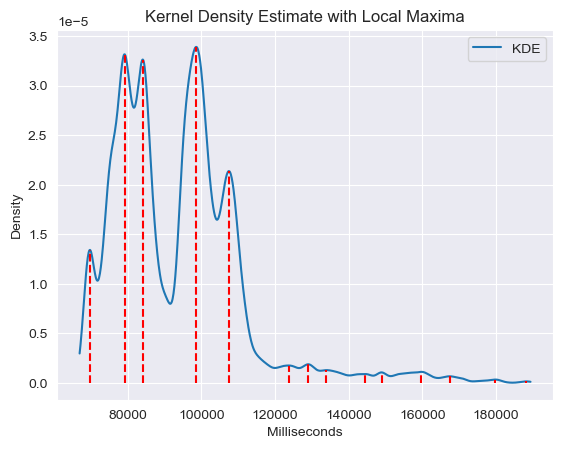

In [39]:
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.stats import gaussian_kde

# Calculate the KDE
kde = gaussian_kde(driver_race_times['milliseconds'])
kde.set_bandwidth(bw_method=kde.factor / 2)
x = np.linspace(driver_race_times_no_outliers['milliseconds'].min(), driver_race_times_no_outliers['milliseconds'].max(), 1000)

# Find the local maxima
local_maxima = argrelextrema(kde(x), np.greater)

# Plot the KDE
plt.plot(x, kde(x), label='KDE')

# Mark the local maxima
for maxima_index in local_maxima[0]:
    maxima = x[maxima_index]
    plt.plot([maxima, maxima], [0, kde([maxima])[0]], 'r--')

plt.title('Kernel Density Estimate with Local Maxima')
plt.xlabel('Milliseconds')
plt.ylabel('Density')
plt.legend()
plt.show()

### Applying KMeans to the data to identify the number of clusters.

The KMEANS method is not the best for this type of data, because the data is not globular. 

But after trying DBSCAN (with no meaningful results) and Agglomerative Clustering, KMeans seemed to be the best option(also based on my computer's processing power).

With scores of :
Silhouette Score: 0.5338166271664853
Calinski Harabasz Score: 170290.80048920712
Davies Bouldin Score: 0.5302588959977541

It seems like a good clustering result, but it is important to remember that the data is not globular and the clusters are not too well-separated.

C:\Users\havva\AppData\Local\Temp\ipykernel_11376\2516946047.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\havva\AppData\Local\Temp\ipykernel_11376\2516946047.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Silhouette Score: 0.5338166271664853
Calinski Harabasz Score: 170290.80048920712
Davies Bouldin Score: 0.5302588959977541


Text(0.5, 1.0, 'K-Means Clustering of Q1 and Q2 times')

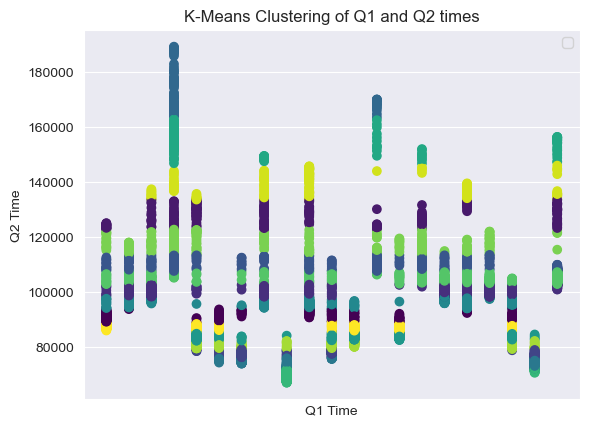

In [40]:
# Create a mapping from 'driverId_cat' to 'driverId'
driverId_mapping = dict(zip(driver_race_times_no_outliers['driverId_cat'], driver_race_times_no_outliers['driverId']))
# Create a new column 'driverId_cat' that represents the categorical version of 'driverId'
driver_race_times_no_outliers['driverId_cat'] = pd.Categorical(driver_race_times_no_outliers['driverId']).codes

kmeans = KMeans(n_clusters=16)
reshape = np.reshape(driver_race_times_no_outliers['milliseconds'].values, (-1, 1))
kmeans.fit(reshape)
driver_race_times_no_outliers['cluster'] = kmeans.predict(reshape)

silhouette_avg = silhouette_score(reshape,driver_race_times_no_outliers['cluster'])
print('Silhouette Score:', silhouette_avg)

chi_score = calinski_harabasz_score(reshape, driver_race_times_no_outliers['cluster'])
print('Calinski Harabasz Score:', chi_score)

db_score = davies_bouldin_score(reshape, driver_race_times_no_outliers['cluster'])
print('Davies Bouldin Score:', db_score)

# Get unique 'driverId_cat' values that have data
unique_driverId_cats = driver_race_times_no_outliers['driverId_cat'].unique()

# Set xticks to the unique 'driverId_cat' values that have data
plt.xticks(unique_driverId_cats)

# Set xtick labels to the corresponding 'driverId' values
plt.gca().set_xticklabels([driverId_mapping[i] for i in plt.gca().get_xticks()])

# Plot the clusters using 'driverId_cat' for the x-axis
plt.scatter(driver_race_times_no_outliers['raceId'], driver_race_times_no_outliers['milliseconds'], c=driver_race_times_no_outliers['cluster'], cmap='viridis')
plt.xlabel('Q1 Time')
plt.ylabel('Q2 Time')
plt.legend()
plt.title('K-Means Clustering of Q1 and Q2 times')

### Interactive Plot of the KMeans clusters

In [41]:
import plotly.graph_objects as go
import plotly.offline as pyo

# Create a trace for the scatter plot
trace = go.Scatter(
    x=driver_race_times_no_outliers['raceId'],
    y=driver_race_times_no_outliers['milliseconds'],
    mode='markers',
    marker=dict(
        size=10,
        color=driver_race_times_no_outliers['cluster'],
        colorscale='Viridis',
        showscale=True
    ),
    text=driver_race_times_no_outliers.apply(
        lambda row: f"Driver ID: {row['driverId']}<br>Race ID: {row['raceId']}<br>Lap Time: {row['milliseconds']}ms",
        axis=1
    ),  # Customize hover text
    hoverinfo='text'  # Show the custom text on hover
)

# Create the layout
layout = go.Layout(
    title='K-Means Clustering of Race Lap Times (2018)',
    xaxis=dict(
        title='Race ID',
        type='category',  # Treat Race ID as categorical
        tickmode='array',
        tickvals=driver_race_times_no_outliers['raceId'].unique(),  # Show all race IDs
        ticktext=driver_race_times_no_outliers['raceId'].unique()  # Display as text labels
    ),
    yaxis=dict(title='Lap Time (milliseconds)'),
)

# Create the figure and add the scatter plot
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
# Show the plot
pyo.plot(fig, filename='race_data_2018_kmeans.html')

PermissionError: [Errno 13] Permission denied: 'race_data_2018_kmeans.html'

### Normalizing the lap times based on the fastest lap time. Easier to compare the driver performace.
This method  can help remove track specific biases and allow for a more accurate comparison of driver performance, but 
is sensitive to outliers.

 The normalized value is calculated as the ratio of each lap time to the fastest lap time of the corresponding race. This normalization allows for a fair comparison of lap times across different races.

In [42]:
fastest_lap_per_race = driver_race_times_no_outliers.groupby('raceId')['milliseconds'].min().reset_index()
print(fastest_lap_per_race)
fastest_lap_per_race.columns = ['raceId', 'fastest_lap']

# Merge the fastest lap times with the original data
driver_race_times_no_outliers = pd.merge(driver_race_times_no_outliers, fastest_lap_per_race, on='raceId')

# Create and calculate the normalized lap time
driver_race_times_no_outliers['normalized_lap'] = driver_race_times_no_outliers['milliseconds'] / driver_race_times_no_outliers['fastest_lap']

    raceId  milliseconds
0      989         85945
1      990         93740
2      991         95785
3      992        105149
4      993         78441
5      994         74260
6      995         73864
7      996         94225
8      997         66957
9      998         90696
10     999         75545
11    1000         80012
12    1001        106286
13    1002         82497
14    1003        101905
15    1004         95861
16    1005         92318
17    1006         97392
18    1007         78741
19    1008         70540
20    1009        100867


### Tried with a elbow method to identify the optimal number of clusters for a DBSCAN model.
The results did not translate well to application on the DBSCAN model. I choose to go with KMeans instead.

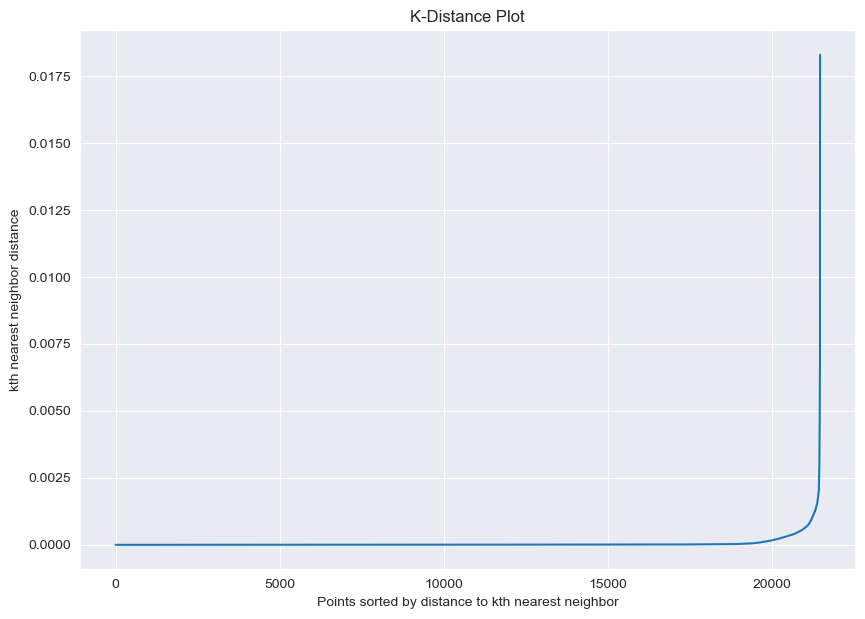

In [43]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Reshape the 'normalized_lap' values
normalized_lap_values = np.reshape(driver_race_times_no_outliers['normalized_lap'].values, (-1, 1))

# Use the NearestNeighbors class to find the k-nearest neighbors
nearest_neighbors = NearestNeighbors(n_neighbors=4)  # Change the value of n_neighbors to the k value you want
nearest_neighbors.fit(normalized_lap_values)

# Get the distances and indices of the k-nearest neighbors for each point
distances, indices = nearest_neighbors.kneighbors(normalized_lap_values)

# Get the distances to the kth nearest neighbor for each point
kth_distances = distances[:, -1]

# Sort the distances
kth_distances = np.sort(kth_distances, axis=0)

# Create the k-distance plot
plt.figure(figsize=(10, 7))
plt.plot(kth_distances)
plt.title('K-Distance Plot')
plt.xlabel('Points sorted by distance to kth nearest neighbor')
plt.ylabel('kth nearest neighbor distance')
plt.show()

### KMeans clustering with the normalized lap times.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Silhouette Score: 0.5276030596583317
Calinski Harabasz Score: 285812.4360608272
Davies Bouldin Score: 0.5007276278663749


Text(0.5, 1.0, 'K-Means Clustering of Q1 and Q2 times')

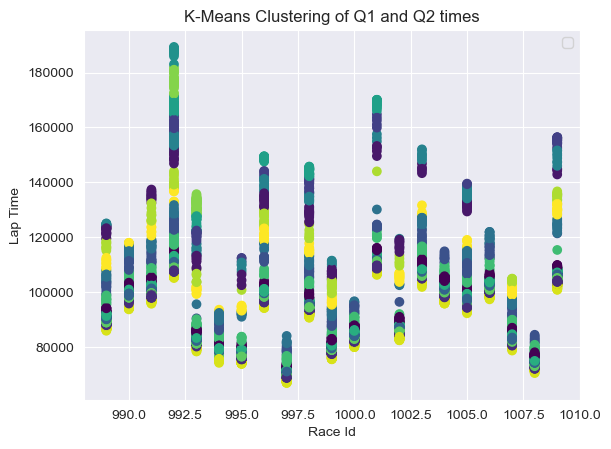

In [44]:
# Create a mapping from 'driverId_cat' to 'driverId'
driverId_mapping = dict(zip(driver_race_times_no_outliers['driverId_cat'], driver_race_times_no_outliers['driverId']))
# Create a new column 'driverId_cat' that represents the categorical version of 'driverId'
driver_race_times_no_outliers['driverId_cat'] = pd.Categorical(driver_race_times_no_outliers['driverId']).codes

kmeans = KMeans(n_clusters=17)
reshape = np.reshape(driver_race_times_no_outliers['normalized_lap'].values, (-1, 1))
kmeans.fit(reshape)
driver_race_times_no_outliers['cluster'] = kmeans.predict(reshape)

silhouette_avg = silhouette_score(reshape,driver_race_times_no_outliers['cluster'])
print('Silhouette Score:', silhouette_avg)

chi_score = calinski_harabasz_score(reshape, driver_race_times_no_outliers['cluster'])
print('Calinski Harabasz Score:', chi_score)

db_score = davies_bouldin_score(reshape, driver_race_times_no_outliers['cluster'])
print('Davies Bouldin Score:', db_score)
#Get unique 'driverId_cat' values that have data
unique_driverId_cats = driver_race_times_no_outliers['driverId_cat'].unique()
#Plot the clusters using 'driverId_cat' for the x-axis
plt.scatter(driver_race_times_no_outliers['raceId'], driver_race_times_no_outliers['milliseconds'], c=driver_race_times_no_outliers['cluster'], cmap='viridis')
plt.xlabel('Race Id')
plt.ylabel('Lap Time')
plt.legend()
plt.title('K-Means Clustering of Q1 and Q2 times')